# 7章：質問応答

In [4]:
from datasets import get_dataset_config_names, load_dataset

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [6]:
subjqa = load_dataset("subjqa", name="electronics")
subjqa["train"]["answers"][1]

Reusing dataset subjqa (/home/ace14385kw/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

In [8]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [14]:
# sampleでランダムな行をサンプリング
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


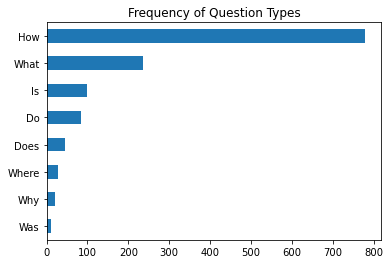

In [15]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

### MinuLMによるQAシステムの構築

In [19]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("deepset/minilm-uncased-squad2")
question = "How much music can this hold?"
context = "An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."
inputs = tokenizer(question, context, return_tensors="pt")
inputs, tokenizer.decode(inputs["input_ids"][0])

({'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
          23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
          25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]])},
 '[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]')

In [20]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("deepset/minilm-uncased-squad2")

with torch.no_grad():
    outputs = model(**inputs)
outputs # QA向けの出力形式であることが確認できる

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)

In [24]:
import torch

start_logits = outputs.start_logits
end_logits = outputs.end_logits

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
answer

'6000 hours'

In [25]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/home/ace14385kw/anaconda3/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:186: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651614248752594, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22083011269569397,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253548622131348,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [27]:
# スライディングウィンドウ戦略による長い入力への対処
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], return_overflowing_tokens=True, max_length=100, stride=25)

for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


### Haystackを用いたQAパイプラインの構築

In [28]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
# Elasticsearchの起動
import os
from subprocess import Popen, PIPE, STDOUT

!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
!sleep 30

[sudo] password for ace14385kw: 


SubprocessError: Exception occurred in preexec_fn.

In [8]:
from haystack.document_stores import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(return_embedding=True)

ImportError: cannot import name '__version__' from 'haystack' (/home/ace14385kw/anaconda3/lib/python3.9/site-packages/haystack/__init__.py)